# Analysis of Twitter Data
## Time Series Visualisation

Another interesting aspect of analysing data from Twitter is the possibility to observe the distribution of tweets over time. In other words, if we organise the frequencies into temporal buckets, we could observe how Twitter users react to real-time events.

One of our favourite tools for data analysis with Python is Pandas, which also has a fairly decent support for time series. As an example, let’s track the hashtag `#bigdata` to observe what happened during the first match.

In [1]:
# from the old code
import re
 
emoticons_str = r"""
    (?:
        [:=;] # Eyes
        [oO\-]? # Nose (optional)
        [D\)\]\(\]/\\OpP] # Mouth
    )"""
 
regex_str = [
    emoticons_str,
    r'<[^>]+>', # HTML tags
    r'(?:@[\w_]+)', # @-mentions
    r"(?:\#+[\w_]+[\w\'_\-]*[\w_]+)", # hash-tags
    r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&amp;+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+', # URLs

    r'(?:(?:\d+,?)+(?:\.?\d+)?)', # numbers
    r"(?:[a-z][a-z'\-_]+[a-z])", # words with - and '
    r'(?:[\w_]+)', # other words
    r'(?:\S)' # anything else
]
    
tokens_re = re.compile(r'('+'|'.join(regex_str)+')', re.VERBOSE | re.IGNORECASE)
emoticon_re = re.compile(r'^'+emoticons_str+'$', re.VERBOSE | re.IGNORECASE)
 
def tokenize(s):
    return tokens_re.findall(s)
 
def preprocess(s, lowercase=True):
    tokens = tokenize(s)
    if lowercase:
        tokens = [token if emoticon_re.search(token) else token.lower() for token in tokens]
    return tokens

In the main loop which reads all the tweets, we simply track the occurrences of the hashtag, i.e. we can refactor the code from the previous episodes into something similar to:

In [4]:
import pandas
import json
import sys

dates_BIGDATA = []

#fname = 'C:\\Program Files\\Anaconda2\\tweets_bigData_dataAnalytic.json'
fname = 'tweets_bigData_dataAnalytic_small.json'

f = open(fname, 'r')
# f is the file pointer to the JSON data set
count = 1
for line in f:
    if (line == '\n'):      # skip empty lines
        continue
    count = count + 1
    if count%500 == 0:
        sys.stdout.write('.')
    if count%35000 == 0:
        sys.stdout.write('\n')
    tweet = json.loads(line)
    # substitute, e.g. \u2026, with space
    tw = re.sub(r'[^\x00-\x7F]+',' ', tweet['text'])
    # let's focus on hashtags only at the moment
    terms_hash = [term for term in preprocess(tw) if term.startswith('#')]
    # track when the hashtag is mentioned
    if '#bigdata' in terms_hash:
        dates_BIGDATA.append(tweet['created_at'])
print('\nDone..')

# a list of "1" to count the hashtags
ones = [1]*len(dates_BIGDATA)
# the index of the series
idx = pandas.DatetimeIndex(dates_BIGDATA)
print(idx)
# the actual series (at series of 1s for the moment)
BIGDATA = pandas.Series(ones, index=idx)
print(BIGDATA)

# Resampling / bucketing
per_10minute = BIGDATA.resample('10Min').sum().fillna(0)
print(per_10minute)

.................................................................
Done..
DatetimeIndex(['2016-10-27 14:07:16', '2016-10-27 14:07:36',
               '2016-10-27 14:07:47', '2016-10-27 14:07:59',
               '2016-10-27 14:08:28', '2016-10-27 14:08:56',
               '2016-10-27 14:10:14', '2016-10-27 14:10:19',
               '2016-10-27 14:10:20', '2016-10-27 14:10:47',
               ...
               '2016-10-28 10:42:41', '2016-10-28 10:42:44',
               '2016-10-28 10:42:49', '2016-10-28 10:43:04',
               '2016-10-28 10:43:05', '2016-10-28 10:43:08',
               '2016-10-28 10:43:12', '2016-10-28 10:43:18',
               '2016-10-28 10:43:19', '2016-10-28 10:43:19'],
              dtype='datetime64[ns]', length=17374, freq=None)
2016-10-27 14:07:16    1
2016-10-27 14:07:36    1
2016-10-27 14:07:47    1
2016-10-27 14:07:59    1
2016-10-27 14:08:28    1
2016-10-27 14:08:56    1
2016-10-27 14:10:14    1
2016-10-27 14:10:19    1
2016-10-27 14:10:20    1
2016-10-2

The last line is what allows us to track the frequencies over time. The series is re-sampled with intervals of 10 minutes. This means all the tweets falling within a particular minute will be aggregated, more precisely they will be summed up. The time index will not keep track of the seconds anymore. If there is no tweet in a particular minute, the `fillna()` function will fill the blanks with zeros.

To put the time series, run these commands:

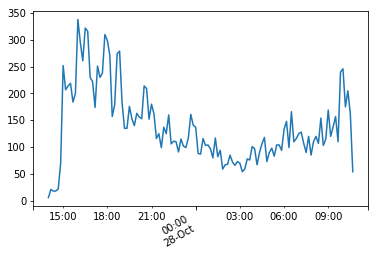

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
per_10minute.plot()
plt.gcf().autofmt_xdate()
plt.show()

Rather than just observing one sequence at a time, we could compare different series to observe how the matches has evolved. 

So let’s refactor the code for the time series, keeping track of the three different hashtags `#bigdata` and `#datascience` into the corresponding pandas.Series.

In [6]:
import pandas
import json
import sys

dates_BIGDATA = []
dates_DATASCIENCE = []

#fname = 'C:\\Program Files\\Anaconda2\\tweets_bigData_dataAnalytic.json'
fname = 'tweets_bigData_dataAnalytic_small.json'

f = open(fname, 'r')
# f is the file pointer to the JSON data set
count = 1
for line in f:
    if (line == '\n'):      # skip empty lines
        continue
    count = count + 1
    if count%500 == 0:
        sys.stdout.write('.')
    if count%35000 == 0:
        sys.stdout.write('\n')
    tweet = json.loads(line)
    # substitute, e.g. \u2026, with space
    tw = re.sub(r'[^\x00-\x7F]+',' ', tweet['text'])
    # let's focus on hashtags only at the moment
    terms_hash = [term for term in preprocess(tw) if term.startswith('#')]
    # track when the hashtag is mentioned
    if '#bigdata' in terms_hash:
        dates_BIGDATA.append(tweet['created_at'])
    if '#datascience' in terms_hash:
        dates_DATASCIENCE.append(tweet['created_at'])

print('\nwait..')
# a list of "1" to count the hashtags
ones = [1]*len(dates_BIGDATA)
# the index of the series
idx = pandas.DatetimeIndex(dates_BIGDATA)
# the actual series (at series of 1s for the moment)
BIGDATA = pandas.Series(ones, index=idx)
# Resampling / bucketing
bd_per_minute = BIGDATA.resample('10Min').sum().fillna(0)

ones = [1]*len(dates_DATASCIENCE)
# the index of the series
idx = pandas.DatetimeIndex(dates_DATASCIENCE)
# the actual series (at series of 1s for the moment)
DATASCIENCE = pandas.Series(ones, index=idx)
# Resampling / bucketing
ds_per_minute = DATASCIENCE.resample('10Min').sum().fillna(0)
print('Done..')

.................................................................
wait..
Done..


In [7]:
# all the data together
match_data = dict(BigData=bd_per_minute, DataScience=ds_per_minute)
# we need a DataFrame, to accommodate multiple series
all_matches = pandas.DataFrame(data=match_data, index=bd_per_minute.index)
# Resampling as above
all_matches = all_matches.resample('10Min').sum().fillna(0)

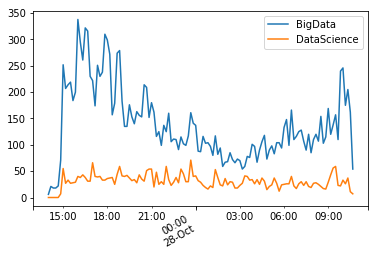

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
all_matches.plot()
plt.gcf().autofmt_xdate()
plt.show()

In [9]:
## Your turn now
## Rather than obeserve the hastags, 
## modify the code to observe the co-occurrences,
## such as '#bigdata', '#datascience', ...

import pandas
import json
import sys

dates_THEVOICETH = []
dates_MTC = []

#fname = 'C:\\Program Files\\Anaconda2\\tweets_bigData_dataAnalytic.json'
fname = 'all_tweet.json'

f = open(fname, 'r')
# f is the file pointer to the JSON data set
count = 1
for line in f:
    if (line == '\n'):      # skip empty lines
        continue
    count = count + 1
    if count%500 == 0:
        sys.stdout.write('.')
    if count%35000 == 0:
        sys.stdout.write('\n')
    tweet = json.loads(line)
    # substitute, e.g. \u2026, with space
    tw = re.sub(r'[^\x00-\x7F]+',' ', tweet['text'])
    # let's focus on hashtags only at the moment
    terms_hash = [term for term in preprocess(tw) if term.startswith('#')]
    # track when the hashtag is mentioned
    if '#thevoiceth' in terms_hash:
        dates_THEVOICETH.append(tweet['created_at'])
    if '#MasterChefThailand' in terms_hash:
        dates_MTC.append(tweet['created_at'])

print('\nwait..')
# a list of "1" to count the hashtags
ones = [1]*len(dates_THEVOICETH)
# the index of the series
idx = pandas.DatetimeIndex(dates_THEVOICETH)
# the actual series (at series of 1s for the moment)
THEVOICE = pandas.Series(ones, index=idx)
# Resampling / bucketing
tv_per_minute = THEVOICE.resample('10Min').sum().fillna(0)

ones = [1]*len(dates_MTC)
# the index of the series
idx = pandas.DatetimeIndex(dates_MTC)
# the actual series (at series of 1s for the moment)
MTC = pandas.Series(ones, index=idx)
# Resampling / bucketing
mtc_per_minute = MTC.resample('10Min').sum().fillna(0)
print('Done..')

......................................................................
......................................................................
......................................................................
.................................
wait..
Done..


In [10]:
# all the data together
match_data = dict(Thevoice=tv_per_minute, Masterchef=mtc_per_minute)
# we need a DataFrame, to accommodate multiple series
all_matches = pandas.DataFrame(data=match_data, index=tv_per_minute.index)
# Resampling as above
all_matches = all_matches.resample('10Min').sum().fillna(0)

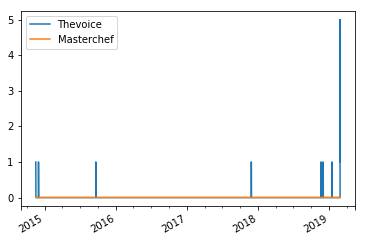

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
all_matches.plot()
plt.gcf().autofmt_xdate()
plt.show()